# Modeling

To see how well we an classify the public's response to the COVID pandemic based on collected tweet, three machine learning models will be explored to see which one we can deploy.In addition to a baseline model, we will see whether a decsion tree classifier, random forest classifier or XGBoost model will be ideal.

## Pros and Cons of Each Model

In [1]:
import seaborn as sns
import pandas as pd
import datetime as dt
import eli5
import waterfall_chart
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be 

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.regressor import PredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import classification_report
from yellowbrick.classifier import ROCAUC
import xgboost as xgb

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# getting tweet df up and running
Master_tweet_dataset = pickle.load(open('Master_Tweet_dataset.pickle','rb'))
Master_tweet_dataset = Master_tweet_dataset.drop('Spread',axis=1)

In [4]:
# Variable Designation
X = Master_tweet_dataset.drop(['Target'],axis=1)
y= Master_tweet_dataset.iloc[:,-1]

In [5]:
#apply the LabelEncoder to y values to get rid of continuous error
lab_enc = LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y)


## Pipeline Creation

While the models that I choose for this project do not need much preparation of the data in terms of scaling and normalization, I utilized Pipelines to assist with parameter tuning via GridSearch and also provide an expectation around model performance. 

In [6]:
#Classifer being used in current Pipeline so future changes can be made
Model = DummyRegressor(strategy='mean')

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

categorical_features = ['Target']
#categorical_transformer = Pipeline([('encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])#,('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

## Data Split
With nearly 25 thousand tweets, a test size of 20% seemed to provide the models with enough training data. I was tempted to select 25%, but I preferred to have more data to train with and could check against overfitting with analysis of ROC curves later.

In [7]:
#splitting of data
X_train, X_test, y_train, y_test = train_test_split(X, training_scores_encoded,test_size=.20)

## Models

### Baseline Model

In [8]:
clf.fit(X_train,y_train,)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['likes_count', 'word_count',
                                                   'avg_word_length',
                                                   'stopwords_count',
                                                   'char_count',
                                                   'Sentiment'])])),
                ('classifier', DummyRegressor())])

In [9]:
clf.score(X_test,y_test)

-2.6647878099472777e-05

### Decision Tree Classifier

### Decision Tree Pros

- Does not require much data preprocessing time, nor does it need the data to be normalized or scaled.
- Able to deal with missing values in the dataset
- Easy to explain to a variety of audiences

### Decision Tree Cons
- Decision tree training can be more computationally expensive than other models and can take more time than others
- Small changes in the data can create instability in the model
- Not ideal for regression or predicting a continuous value


In [10]:
#Classifer being used in current Pipeline so future changes can be made
Model = DecisionTreeClassifier()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['username']
#categorical_transformer = Pipeline([('Encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)#('cat', categorical_transformer, categorical_features)
        ])
    
clf_DT = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])



In [11]:
## Finding best parameters
parameters={'criterion': ('gini','entropy'), 'splitter': ('best', 'random')}

model = DecisionTreeClassifier()

clf_DT = GridSearchCV(model, parameters)

clf_DT.fit(X_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'splitter': ('best', 'random')})

In [12]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Decision Tree Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_DT.best_params_)
print('\n The best score achieved is: \n',clf_DT.best_score_ )
print('\n ============================================================================================')



 Results of the GridSearchCV on Decision Tree Classifier


 The best parameters to use in a model are: 
 {'criterion': 'gini', 'splitter': 'best'}

 The best score achieved is: 
 1.0



In [15]:
#fitting and making predictions with model
clf_DT = DecisionTreeClassifier(criterion='gini',splitter='best')
clf_DT_model = clf_DT.fit(X_train,y_train)

#saving model - run this when data is refreshed
#pickle.dump( clf_DT_model, open( "clf_DT_model.p", "wb" ) )

#loading model
clf_DT = pickle.load( open( "pickles/clf_DT_model.p", "rb" ) )

#ypred_DT = clf_DT.predict(X_test)

## Understanding Confusion Matrix

Confusion Matrices provide a straightforward visual to see how well your model is performing. By this, the diagonal numbers read from left to right display the number of correct classifications that your model made. For these visualizations, the diagonals shaded in red highlight the correct predictions. The other diagonal present informs on how many classifications were done incorrectly.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


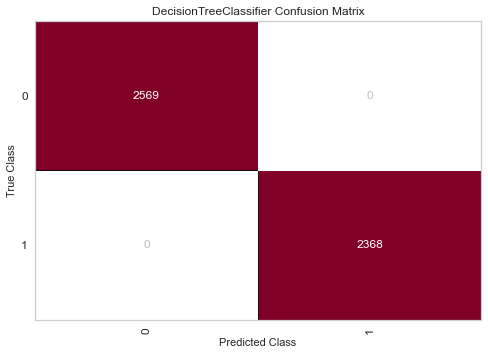

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
#Confusion Matrix
model = DecisionTreeClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Understanding a Classification Report - Yellowbrick documentation

- **Precision:** How many of our predictions are correct?
Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”


- **Recall:** How well do you notice the phenomenon?
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”


- **F1 score:**
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.


- **Support:**
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

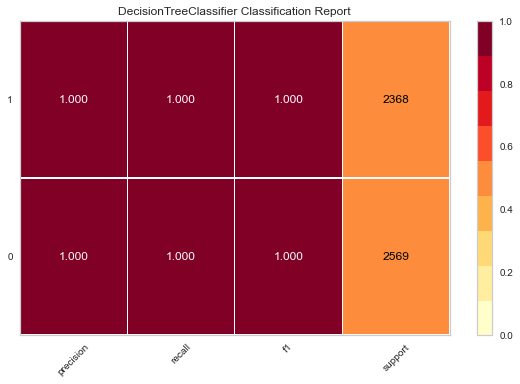

In [17]:
#classification report
visualizer = classification_report(model,X_train, y_train, X_test, y_test, support=True)

### Random Forest Classifier

### Random Forest Pros
- Perform well on large data sets or data sets with missing values
- As an ensemble model, error is minimized as inputs are gathered from all trees to determine an outcome. Variance and overall error are reduced
- Not prone to overfitting and can deal well with outliers

### Random Forest Cons
- Can be thought of as a black box and not as easy to explain how the model works
- Features without any importance won't be of any benefit to the model

In [18]:
## Finding best parameters
parameters={'n_estimators': (100,500,1100), 'criterion': ('gini', 'entropy'),
           'max_features': ('auto', 'sqrt', 'log2')}

model = RandomForestClassifier()

clf_RFC = GridSearchCV(model, parameters)

In [23]:
clf_RFC = clf_RFC.fit(X_train,y_train)

In [24]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Random Forest Classifier')#
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_RFC.best_params_)
print('\n The best score achieved is: \n',clf_RFC.best_score_ )



 Results of the GridSearchCV on Random Forest Classifier


 The best parameters to use in a model are: 
 {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1100}

 The best score achieved is: 
 0.9989869955406612


In [25]:
#Classifer being used in current Pipeline so future changes can be made
Model = RandomForestClassifier(criterion='entropy',max_features='log2',n_estimators=1100)

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['username']
#categorical_transformer = Pipeline([('Encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)#('cat', categorical_transformer, categorical_features)
        ])
    
clf_RFC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])



In [26]:
#Fitting the model
clf_RFC_model = clf_RFC.fit(X_train,y_train)

#saving model
#pickle.dump( clf_RFC_model, open( "clf_RFC_model.p", "wb" ) )

#loading model
clf_RFC = pickle.load( open( "pickles/clf_RFC_model.p", "rb" ) )

#Making predictions with the model
#ypred_RFC = clf_RFC.predict(X_test)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


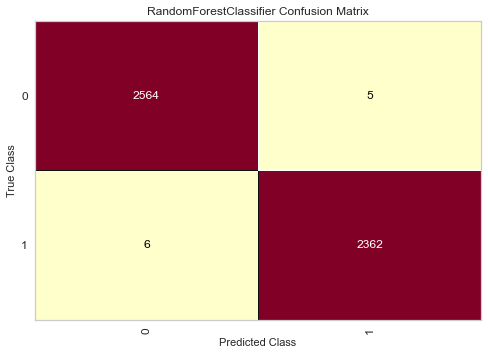

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [27]:
#ConfusionMatrix
model = RandomForestClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


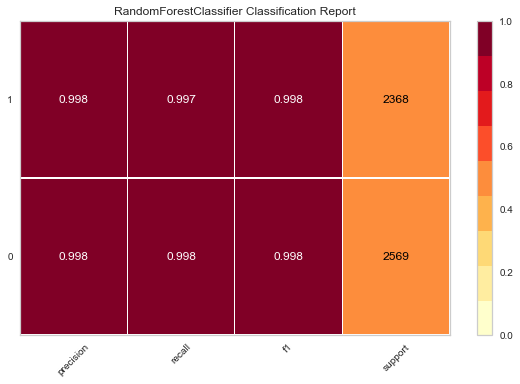

In [28]:
#classification report
visualizer = classification_report(model,X_train, y_train, X_test, y_test, support=True)

### XGBoost Classifier

### XGBoost Pros
- Handles large datasets and is relatively fast to train computationally
- Less prone to overfitting and often delivers superior performance to other models
- Outliers do not affect model and no need for scaling or normalization of data

### XGBoost Cons
- Hard to fine tune parameters as they are plentiful
- Difficult to visualize findings
- Overfitting possible if tuning of parameters isn't done well

In [29]:
#creating DMatrix - not used, but wanted to try as I read up on it in documentation
data_dmatrix = xgb.DMatrix(data=X,label=training_scores_encoded)

In [30]:
## Finding best parameters
parameters={'learning_rate': (0.01,0.25,0.75), 'n_estimators': (100,1000),
           'max_depth': (3,4,5)}

model = xgb.XGBClassifier()

clf_XGB = GridSearchCV(model, parameters)

In [33]:
clf_XGB.fit(X_train,y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': (0.01, 0.25, 0.75),
                         'max_depth': (3, 4, 5), 'n_estimators': (100, 1000)})

In [34]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on XGBoost Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_XGB.best_params_)
print('\n The best score achieved is: \n',clf_XGB.best_score_ )



 Results of the GridSearchCV on XGBoost Classifier


 The best parameters to use in a model are: 
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

 The best score achieved is: 
 1.0


In [35]:
#Classifer being used in current Pipeline so future changes can be made
Model = xgb.XGBClassifier(learning_rate= 0.01,max_depth=3, n_estimators= 100)

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['username']
#categorical_transformer = Pipeline([('encoder',LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf_XGB = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [36]:
#fitting and making predictions with model
#clf_XGB = Model
clf_XGB_model = clf_XGB.fit(X_train,y_train)

#saving the model
#pickle.dump(clf_XGB_model , open( "clf_XGB_model.p", "wb" ) )

#loading the model
clf_XGB = pickle.load( open( "pickles/clf_XGB_model.p", "rb" ) )

#ypred_XGB = clf_XGB.predict(X_test)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


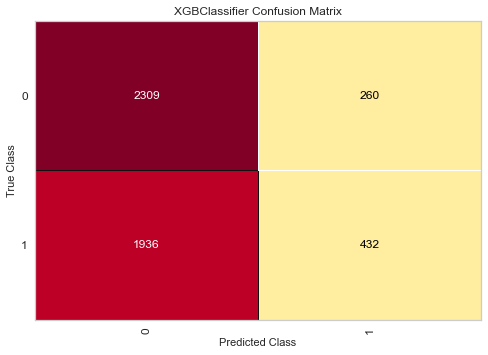

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [37]:
#ConfusionMatrix
model = clf_XGB_model
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


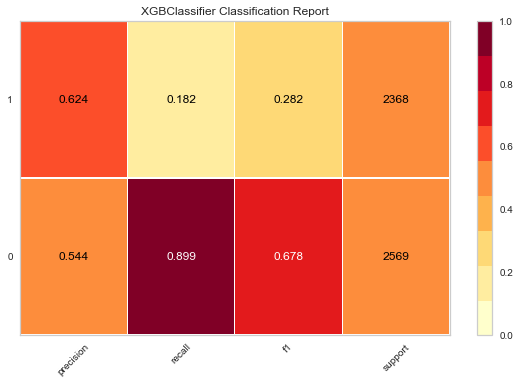

In [38]:
#classification report
visualizer = classification_report(clf_XGB_model,X_train, y_train, X_test, y_test, support=True)

## Model Selection

In [39]:
#ROC curves
#def ROC_Curve (Model, X,y):
    #X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15)
    #model = Model
    #visualizer = ROCAUC(Model)

    #visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    #visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    #visualizer.show()     
    
from functions.Capstone_functions import *

In [40]:
model_selection = [clf_DT_model,clf_RFC_model,clf_XGB_model]
interact(ROC_Curve,Model=model_selection,X=fixed(X),y=fixed(training_scores_encoded))

interactive(children=(Dropdown(description='Model', options=(DecisionTreeClassifier(), Pipeline(steps=[('prepr…

<function functions.Capstone_functions.ROC_Curve(Model, X, y)>

# Model Choice

With minimal difference between the Random Forest and XGBoost model in terms of precision and recall, the deciding factor was which model could possibly fit unseen data the best. Based on the ROC curves above, the RandomForest Classifier is the better model for making predictions with data that has not yet been seen.

In [41]:
#Feature importances of XGBoost model
for feat, importance in zip(X.columns, clf_XGB.feature_importances_):
    print ('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: likes_count, importance: 0.7712000608444214
feature: positive, importance: 0.03914665803313255
feature: death, importance: 0.04437295347452164
feature: word_count, importance: 0.03290253132581711
feature: avg_word_length, importance: 0.0
feature: stopwords_count, importance: 0.0
feature: char_count, importance: 0.0
feature: Sentiment, importance: 0.0
feature: Biden (D), importance: 0.03875676915049553
feature: Trump (R), importance: 0.023475270718336105
feature: Topic, importance: 0.028665093705058098


In [42]:
#Feature Importances in Visual Form
(pd.Series(clf_XGB.feature_importances_, index=X_train.columns)
   .nlargest(len(X.columns))
   .plot(kind='barh'))   

ValueError: Length of passed values is 12, index implies 11.